# Importing weather, sorting and filtering

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
from fuzzywuzzy import process

import matplotlib.pyplot as plt
import os
print(os.getcwd())
#reading weather data and inspecting
weatherV1 = pd.read_csv(r"C:\Users\iftah\Desktop\data analyst studies\project\Ivry B\weather_usa.csv", header=0)
weatherV1.head()
weatherV1.dtypes

C:\Users\iftah\Python Projects\Weather VS. Bees


C:\Users\iftah\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


STATION             object
NAME                object
DATE                 int64
PRCP               float64
PRCP_ATTRIBUTES     object
TAVG               float64
TAVG_ATTRIBUTES     object
TMAX               float64
TMAX_ATTRIBUTES     object
TMIN               float64
TMIN_ATTRIBUTES     object
TSUN               float64
TSUN_ATTRIBUTES     object
dtype: object

## renaming and removing irrelevant information

In [5]:
weather_filtered = pd.DataFrame(weatherV1[['NAME','DATE','PRCP','TAVG','TMAX','TMIN']])
weather_filtered.columns = ['STATE','YEAR','RAIN','avgT','maxT','minT']
weather_filtered['STATE'] = weather_filtered['STATE'].astype('string')
weather_filtered['STATE'] = weather_filtered['STATE'].apply(lambda x: x.split(',')[1].replace('US', '').strip())
states_count = weather_filtered.shape[0] / 4 #number of obesravtions for each year

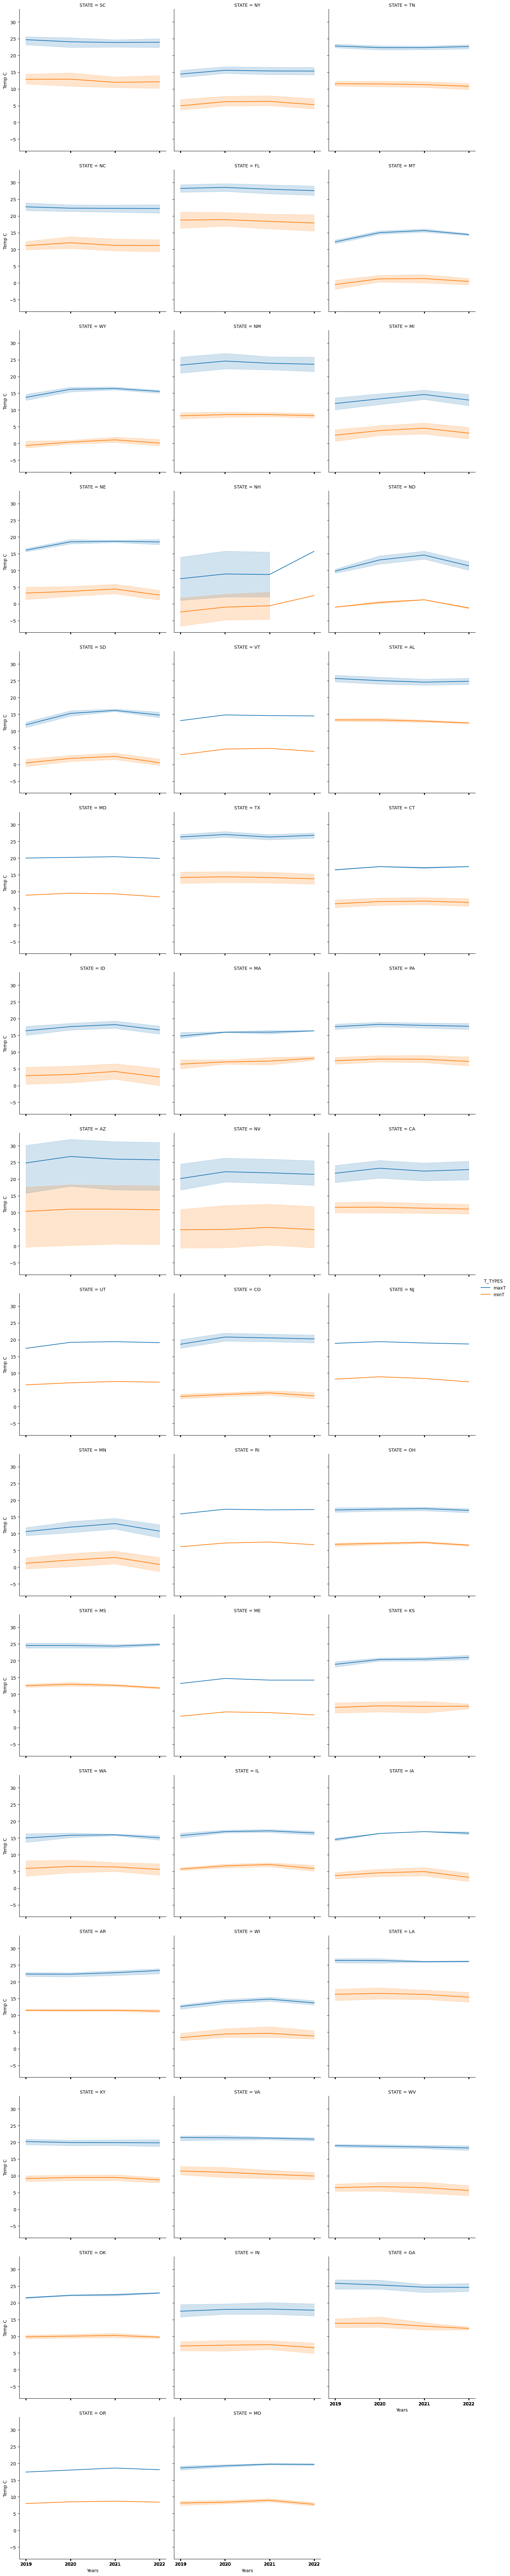

In [6]:
#inspecting data, visualizing
%matplotlib inline
melt_weather = pd.melt(weather_filtered, id_vars=['STATE','YEAR'],value_vars=['maxT','minT'],var_name = 'T_TYPES',value_name='T_VALUES')
melt_weather.head()
g = sns.relplot(data = melt_weather,x='YEAR',y='T_VALUES',hue='T_TYPES', col='STATE', kind='line',col_wrap=3, height=5, aspect=1)
g.set(xlabel="Years",ylabel="Temp C")
plt.xticks(weather_filtered['YEAR'])
plt.show()

## renaming abbreviations to full names

In [7]:
#sorting and matching state abbreviations with full name for later merge
state_ab = pd.read_csv(r"C:\Users\iftah\Desktop\data analyst studies\project\Ivry B\states_abbreviations.csv")
state_ab.head()
state_ab1 = pd.concat([state_ab[['STATE(TERRITORY)', 'Unnamed: 1']].rename(columns={'STATE(TERRITORY)': 'STATE', 'Unnamed: 1': 'ABBREVIATION'}),
                      state_ab[['STATE(TERRITORY).1', 'Unnamed: 3']].rename(columns={'STATE(TERRITORY).1': 'STATE', 'Unnamed: 3': 'ABBREVIATION'}),
                      state_ab[['STATE(TERRITORY).2', 'Unnamed: 5']].rename(columns={'STATE(TERRITORY).2': 'STATE', 'Unnamed: 5': 'ABBREVIATION'})],
                      ignore_index=True)
state_ab1.set_index('ABBREVIATION', inplace = True)
weather_filtered['STATE'] = weather_filtered['STATE'].apply(lambda x: state_ab1.loc[x][0])
weather_filtered.head()

,STATE,YEAR,RAIN,avgT,maxT,minT
0,South Carolina,2019,1256.5,20.0,25.6,14.4
1,South Carolina,2020,1365.2,20.1,25.3,14.8
2,South Carolina,2021,1492.2,19.2,24.7,13.6
3,South Carolina,2022,1274.2,19.5,25.0,14.0
4,New York,2019,1170.8,9.8,15.0,4.5


In [8]:
""" another option for applying abbreviation to full name
dict = {}
for a,b in state_ab1.iterrows():
    dict.a=b[0]\
    """

' another option for applying abbreviation to full name\ndict = {}\nfor a,b in state_ab1.iterrows():\n    dict.a=b[0]    '

# LEADS importing, sorting, and filtering

In [64]:
#importing states the organization and president from the leads gathering excel
leads_1 = pd.read_csv\
(r"C:\Users\iftah\Desktop\data analyst studies\project\Ivry B\Leads_cleaning\4duplicates remove and merge with other source\1csvleads_merged_cleaned.csv",\
 header=0, dtype = 'string')
#observations with contact name are up-to-date organizatoina
leads_1.head()

,state,organization,site,contact name,function,email
0,alabama,alabama beekeepers association,https://www.alabamabeekeepers.com/,damon wallace,president,damonwallace.beeman@gmail.com
1,alabama,blount county beekeepers association,http://www.k4vb.com/regional associations/blco...,harold deason,president,none
2,alabama,etowah county beekeepers association,http://etowahbeekeepers.org/,wil montgomery,president,nwm@juno.com
3,alabama,jefferson county bee keepers,none,danielle dowell,president,none
4,alabama,walker county beekeepers association,https://www.facebook.com/walker-county-beekeep...,president lonnie,president,funter@otelco.net


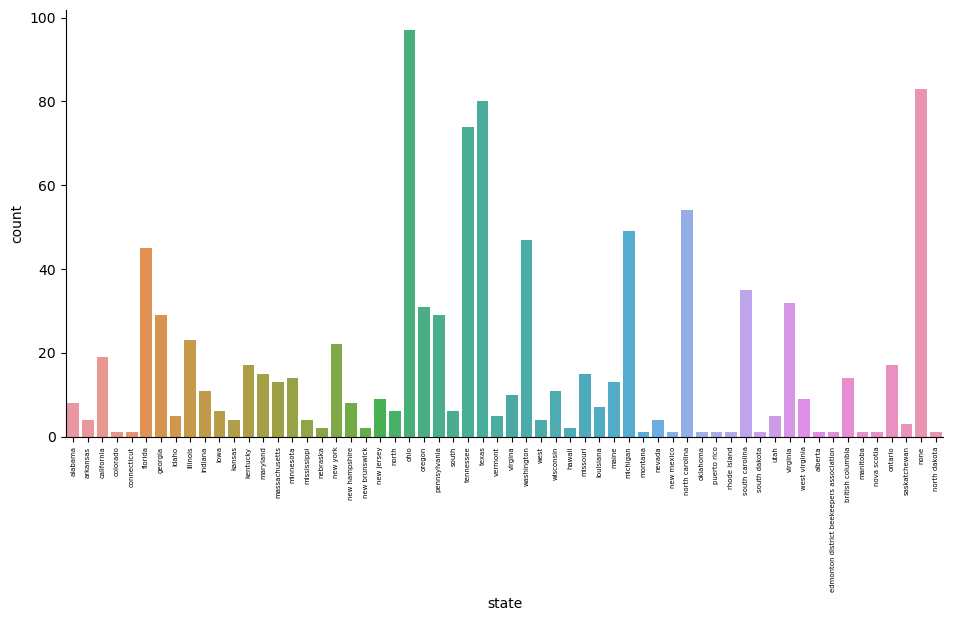

In [65]:
#plotting and inspecting the new dataframe
#print(leads_1['state'].value_counts())
#print(leads_1.info())
#print(leads_1.describe())
g1 = sns.catplot(data = leads_1, kind='count', x='state', height = 5, aspect =2 )
plt.xticks(rotation=90, fontsize=5)
plt.show()
#ohio and texas has a very high count, also none states. will check for duplicates and nulls in the dataframe

In [66]:
#sorting and filtering leads dataframe
(leads_1['contact name'] != 'none').sum()
#472 are 100% up-to-date organizations, we have duplicates and none values
duplicates = leads_1.loc[(leads_1['organization'].duplicated(keep=False)) | (leads_1['email'].duplicated(keep=False) & (leads_1['email'] != 'none'))].\
sort_values('organization').apply(lambda x: x.str.strip().str.lower())
#partly missing information in different fields of the same organz, merge needed, not counting empty emails

(duplicates['organization']=='none').value_counts()
#need to treat the none organizations also

False    242
True     104
Name: organization, dtype: Int64

In [67]:
#we"ll use our function from another project, but also specify the "none" strings values
def select_longer_text(x):
    try:
        if x.iloc[0] == "none":
            return x.iloc[1]
        elif x.iloc[1] == "none":
            return x.iloc[0]
        elif len(x.iloc[0]) >= len(x.iloc[1]):
            return x.iloc[0]
        else:
            return x.iloc[1]
    except IndexError:
            return x

In [68]:
mergedTwins = duplicates.groupby('organization', as_index=False).\
agg({'state':select_longer_text, 'contact name':select_longer_text,\
                                                                    'email':select_longer_text, 'site':select_longer_text,\
                                                                    'function':select_longer_text}).sort_values('organization')
#got rid of none organizations values
mergedTwins.head(10)
print((mergedTwins['organization']=='none').value_counts())
mergedTwins = mergedTwins.loc[mergedTwins['organization'] != 'none']
print((mergedTwins['organization']=='none').sum())

False    144
True       1
Name: organization, dtype: Int64
0


In [69]:
#now well dropr the irrelevent observations of the duplicates and keep the merged once
leads_1.drop(index = duplicates.index, inplace = True)

In [71]:
#prepre for merge, reorder the merged and append
mergedTwins = mergedTwins[['state', 'organization', 'site', 'contact name', 'function', 'email']]
mergedTwins.head()
leads_1_clean = pd.concat([leads_1, mergedTwins]).sort_values(['state', 'organization']).reset_index(drop=True)
leads_1_clean.head()

,state,organization,site,contact name,function,email
0,alabama,alabama beekeepers association,https://www.alabamabeekeepers.com/,damon wallace,president,damonwallace.beeman@gmail.com
1,alabama,blount county beekeepers association,http://www.k4vb.com/regional associations/blco...,harold deason,president,none
2,alabama,etowah county beekeepers association,http://etowahbeekeepers.org/,lonnie funderburg,president,nwm@juno.com
3,alabama,jefferson county bee keepers,none,danielle dowell,president,none
4,alabama,walker county beekeepers association,https://www.facebook.com/walker-county-beekeep...,president lonnie,president,funter@otelco.net
